In [11]:
using JuMP, Gurobi, Random, CSV, DataFrames, Statistics, JLD2, FileIO
model_type="model_with_k";
include("scripts/"*model_type*"/display.jl")
include("scripts/"*model_type*"/model.jl");
include("scripts/"*model_type*"/run.jl");

# Map big - Simul 1

In [2]:
# Simulations with map_title= "vbs_U30_BIG_cust_C20_BIG"
# =========== 1: 10 locs, 5 cust, 4 veh
nb_locs=10; vbs_ind=[1,3,5,7,9,20,23,11,13,26];nb_cust=5;cust_ind=[1,3,5,7,9];nb_veh=4;depot_locs = [1,2,7,8];hubs_ind=[2,5];

### Inputs

In [3]:
const dr_speed = 5 # nb of minutes per km when driving;
const wk_speed = 12 # nb of minutes per km when walking;

# Map & ts-network parameters
map_title= "vbs_U30_BIG_cust_C20_BIG"
horizon = dr_speed*2500									
tstep = 500;

#hubs_ind=[5,14,26];
#nb_locs=30; vbs_ind=1:nb_locs;
#nb_cust=10; cust_ind=1:nb_cust;

# Model Inputs
#nb_veh=5;
G = 1.5 # max driving detour ratio for customers (if W=2: driving time must be inferior to 2*gamma["driving"])
Gtype= "shortestpathpercent" # or "absolutetime"
Wk = 120 # max walking time for customers from origin or to destination
Q= 8 # vehicle capacity;
#depot_locs = [3,4,3,4,3]#[rand(1:nb_locs) for i in 1:nb_veh] # in new indices

datafolder="data/"*map_title*"/";
map_inputs = (datafolder,hubs_ind,vbs_ind,nb_locs,cust_ind,nb_cust,horizon,tstep)
model_inputs = (G,Gtype,Wk,nb_veh,Q,depot_locs);

### Display map & create network

In [4]:
map, tsnetwork, params, cust, vbs, arcs, wo, wd, abbrev,shortest_time = create_network(map_inputs, model_inputs);
q, t, I, K=abbrev;

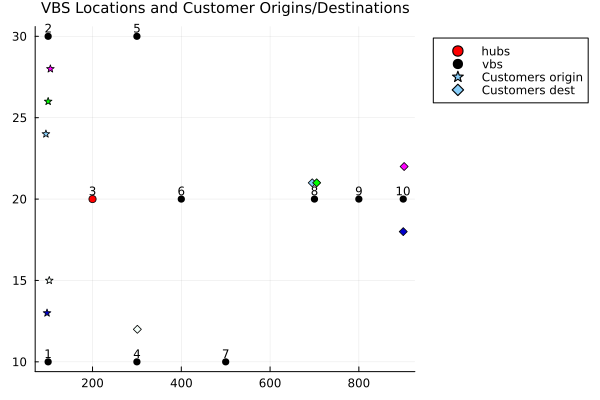

Cust 1, load 1 - Pick-up vbs: [2], Drop-off vbs: [8], 	 depart at: 0.0, arrival before: 9500.0
Cust 2, load 1 - Pick-up vbs: [2], Drop-off vbs: [8], 	 depart at: 0.0, arrival before: 9500.0
Cust 3, load 1 - Pick-up vbs: [2], Drop-off vbs: [10], 	 depart at: 0.0, arrival before: 11500.0
Cust 4, load 1 - Pick-up vbs: [1], Drop-off vbs: [10], 	 depart at: 0.0, arrival before: 11500.0
Cust 5, load 1 - Pick-up vbs: [1], Drop-off vbs: [4], 	 depart at: 0.0, arrival before: 3000.0


In [5]:
# Show map
display(map)
for i in I
    load= q[i]
    println("Cust $i, load $load - Pick-up vbs: ", params.vo[i], ", Drop-off vbs: ", params.vd[i], ", \t depart at: ", round(t[i],digits=1), ", arrival before: ", params.deadlines[i])
end

In [6]:
# Print number of nodes and arcs
if true
    println("Initialized time space network with...")
    println("Num nodes (total) = ", tsnetwork.numnodes)
    println("Num arcs (total) = ", tsnetwork.numarcs);
    for i in I
        println("Num arcs for Cust $i = ", length(params.Ai[i]))
    end
end

Initialized time space network with...
Num nodes (total) = 286
Num arcs (total) = 2507
Num arcs for Cust 1 = 635
Num arcs for Cust 2 = 635
Num arcs for Cust 3 = 875
Num arcs for Cust 4 = 885
Num arcs for Cust 5 = 13


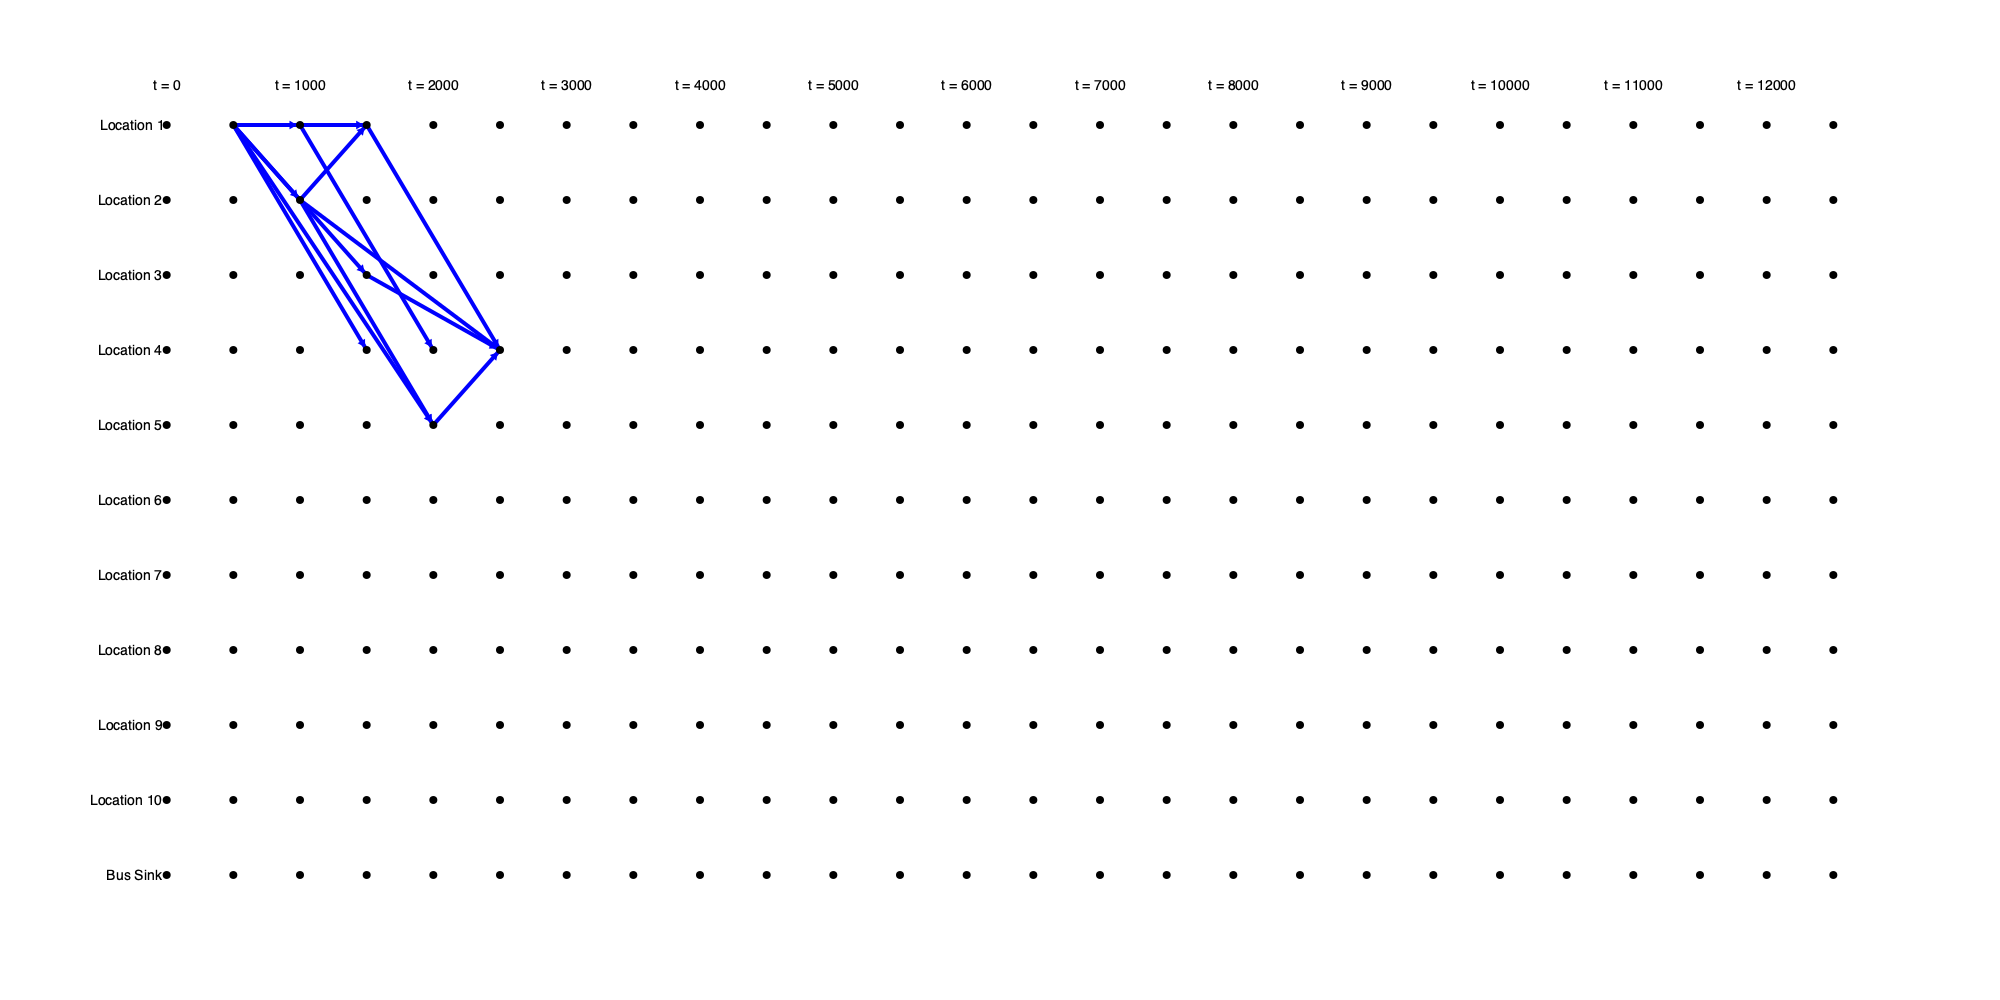

In [7]:
# To visualize some arcs
if true
    timespaceviz_arcs("viz.png", horizon, tstep, tsnetwork, params.Ai[5], x_size=2000, y_size=1000)
end

### Model & Results

Best obj: 17773, Root relaxation obj 17766 ==> 0.03% gap

In [8]:
# Model objective coefficients
mu=1 # coefficient in front of walking time
beta=1 # coefficient in front of waiting time
lambda=1 # transfer penalty
alpha1=0.01 # coefficient in front of vehicle driving time and utilization 
nu=10 # coefficient in front of vehicle utilization
alpha2=0 # coefficient in front of unmet demand
coefficients=mu,beta,lambda,alpha1,nu,alpha2;

In [9]:
xi,x,z,obj,solvetime,objs=network_model_v2(Q,abbrev,wo,tsnetwork,params,coefficients,1);

Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-04
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 69800 rows, 34382 columns and 209406 nonzeros
Model fingerprint: 0xbeaa9f49
Variable types: 0 continuous, 34382 integer (34382 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+00]
  Objective range  [1e-01, 1e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 39036 rows and 15330 columns
Presolve time: 4.11s
Presolved: 30764 rows, 19052 columns, 98697 nonzeros
Variable types: 0 continuous, 19052 integer (19052 binary)

Root relaxation: objective 1.776686e+04, 3915 iterations, 0.30 seconds (0.98 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 17766.8587    0  

In [12]:
save_res = true; # to save the results in the result folder
resultfolder="results/"*model_type*"/"*map_title*"/";

In [15]:
if save_res
    if !isdir(resultfolder)
        mkdir(resultfolder)
    end
    jldsave(resultfolder*"K"*string(nb_veh)*"_nlocs"*string(nb_locs)*"_ncust"*string(nb_cust)*"_Q"*string(Q)*"_Wk"*string(Wk)*".jld2", xi=xi, x=x, z=z)
end

#### Results

In [17]:
xi,x,z=load(resultfolder*"K"*string(nb_veh)*"_nlocs"*string(nb_locs)*"_ncust"*string(nb_cust)*"_Q"*string(Q)*"_Wk"*string(Wk)*".jld2", "xi", "x", "z");

KPIs

In [18]:
display_KPIs(xi,x,z,tsnetwork,params,I,K,q,wo,t,false)


 Customer KPIs:


Mean #transfers: 0.0
Mean waiting time: 436.0
Mean walking time: 105.0
Mean travel time: 3003.0
Mean efficiency: 0.96

 Vehicle KPIs:
# vehicles used: 2.0


Mean distance: 501.0
Mean capacity: 1.625
Mean service time: 2504.0
Mean carrying time: 2504.0


### Visualizations

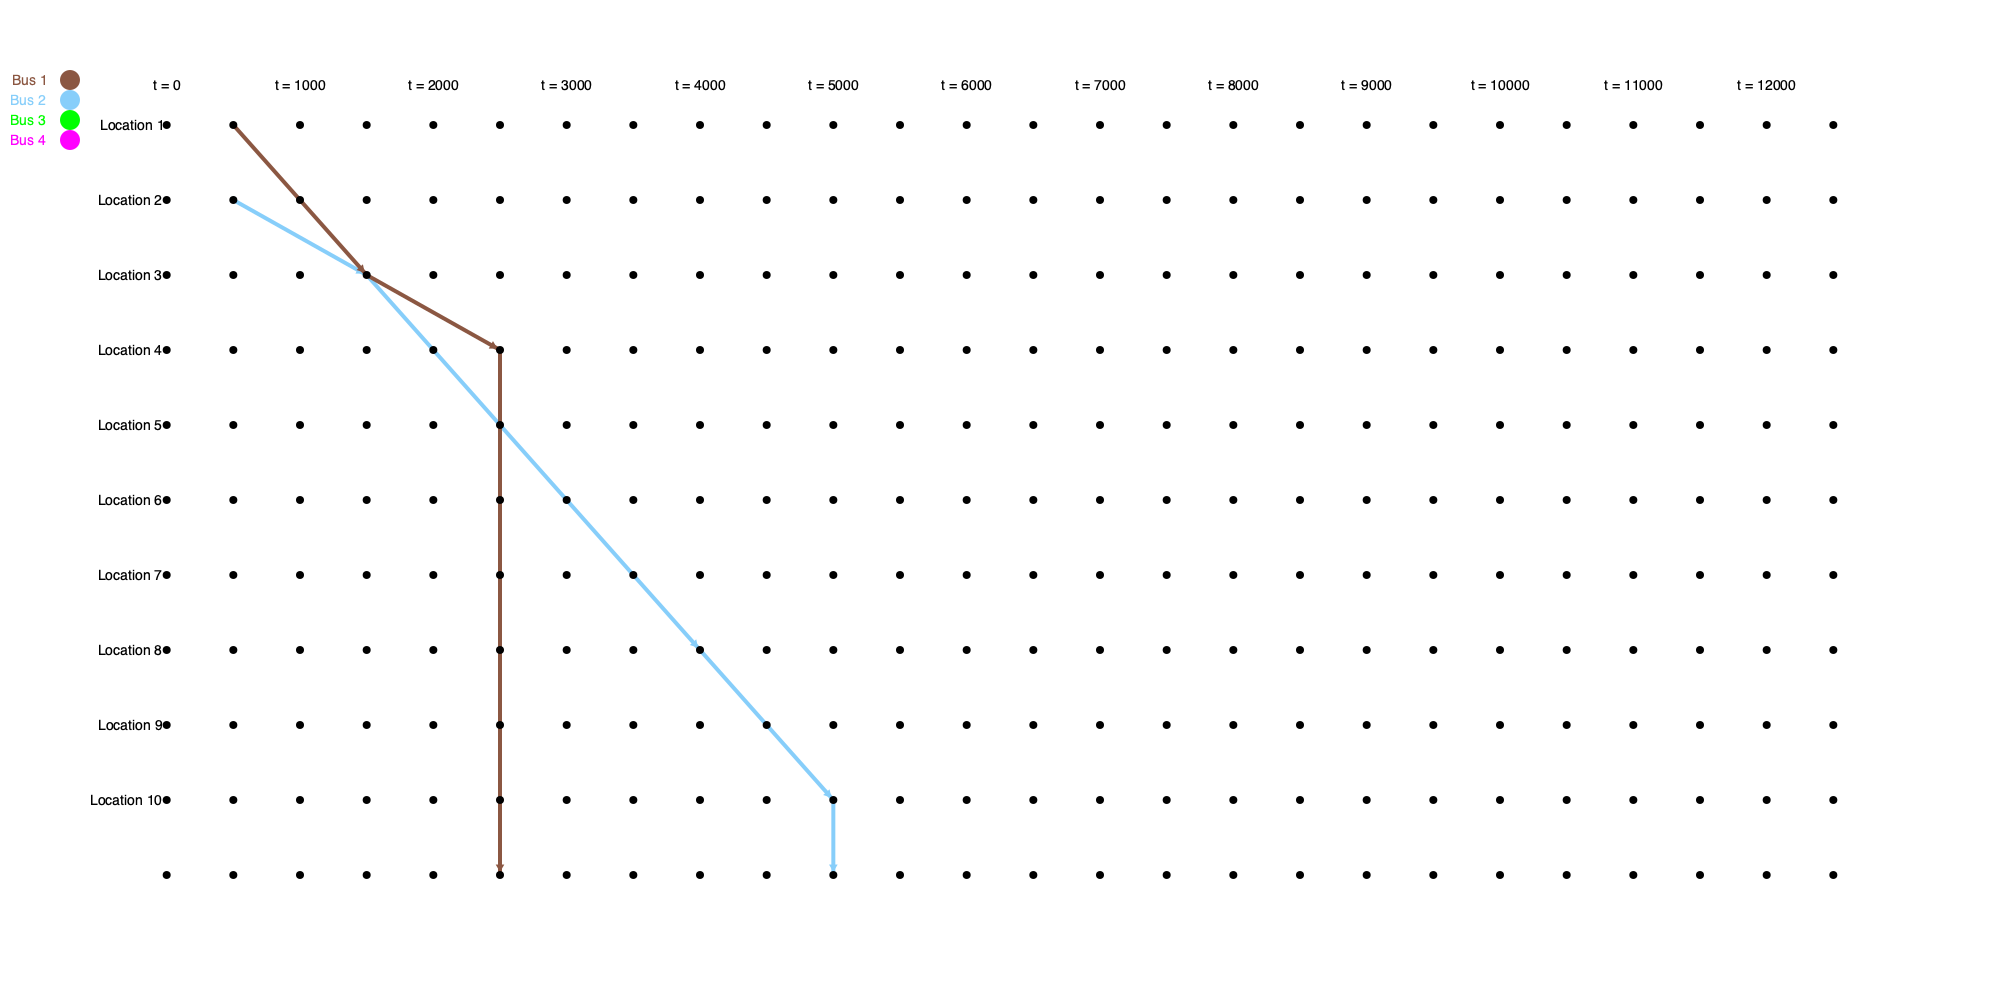

In [19]:
arcdict=Dict()
for k in K
    # list of arcs traveled by vehicle k
    arcdict[k] = [a for a in params.A if z[k,a]==1]
end
timespaceviz_bus("viz.png", horizon, tstep, tsnetwork, arcdict, x_size=2000, y_size=1000)
#timespaceviz_bus(resultfolder*"viz.png", horizon, tstep, tsnetwork, arcdict, x_size=2000, y_size=1000)

Traveling arcs used:
Bus 1:


	 Time 500: from loc 1 to 3, with cust [4, 5]
	 Time 1500: from loc 3 to 4, with cust [5]
	 Time 2500: from loc 4 to 11


Bus 2:
	 Time 500: from loc 2 to 3, with cust [1, 2, 3]
	 Time 1500: from loc 3 to 8, with cust [1, 2, 3, 4]
	 Time 4000: from loc 8 to 10, with cust [3, 4]
	 Time 5000: from loc 10 to 11


Bus 3:
Bus 4:


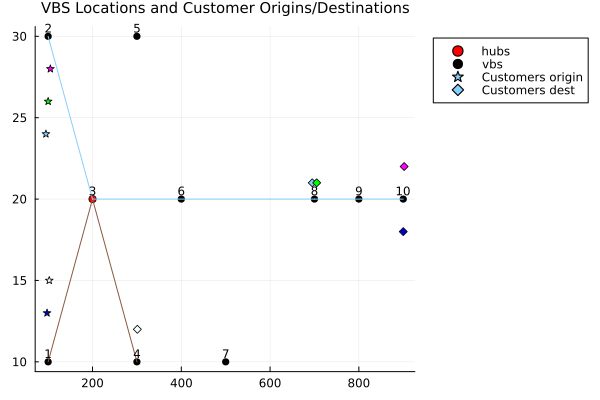

In [20]:
ts=0 # time from which we want to print the arcs
map2=print_traveling_arcs(z,ts,params.P,params.Ia,K,map,vbs,tsnetwork)